In [2]:
pip install torchinfo

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import matplotlib.animation as animation
from IPython.display import HTML

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset
from torchinfo import summary
import functools
from torch.autograd import Variable
from torch.optim import lr_scheduler

In [4]:
print(torch.cuda.device_count())
device = torch.device("cuda:0" if (torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")
if torch.cuda.device_count()>0:
  print(torch.cuda.get_device_name())

1
Tesla P100-PCIE-16GB


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Set parameters
BATCH_SIZE = 64
IMG_SIZE = 128
MEAN = [0.5, 0.5, 0.5]
STD = [0.5, 0.5, 0.5]
transform = T.Compose([T.Resize((IMG_SIZE,IMG_SIZE))
                       ,T.CenterCrop(IMG_SIZE)
                       ,T.ToTensor()
                       ,T.Normalize(MEAN,STD)
                      ])
# Dataloading function
def dataset_loader(img_path, transform):
  data = torchvision.datasets.ImageFolder(root = img_path,
                                          transform = transform)
  data_loader = torch.utils.data.DataLoader(data
                                          ,batch_size = BATCH_SIZE
                                          ,shuffle = True)
  return data_loader

img_path = "/content/drive/MyDrive/Liminal Photos"

In [7]:
liminal_loader = dataset_loader(img_path,transform)

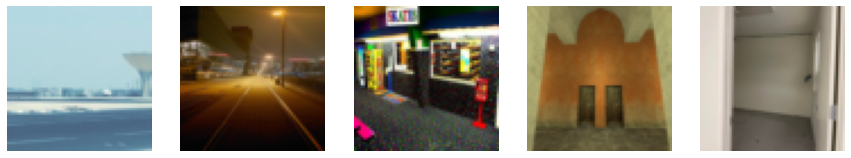

In [8]:
images = next(iter(liminal_loader))[0]
fig, ax = plt.subplots(1,5)
fig.set_figheight(30)
fig.set_figwidth(15)
for i in range(5):
    x = images[i]* torch.tensor(STD)[:, None, None] + torch.tensor(MEAN)[:, None, None]
    ax[i].imshow(x.squeeze().permute(1,2,0))
    ax[i].axis("off")

In [9]:
# num channels
nc = 3

# generator input/latent vector z
nz = 100

# feature map size in gen
ngf = IMG_SIZE

# feature map size in disc
ndf = IMG_SIZE

# epochs
epochs = 50

# learning rate
lr = 0.0002

# beta for Adam
beta1 = 0.5

In [1]:
# initialize starting weights from normal dist with mean = 0 and std = 0.2 per DCGAN Paper
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [10]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.gen = nn.Sequential(nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False)
                              ,nn.BatchNorm2d(ngf*8)
                              ,nn.ReLU(True)

                              ,nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False)
                              ,nn.BatchNorm2d(ngf*4)
                              ,nn.ReLU(True)

                              ,nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False)
                              ,nn.BatchNorm2d(ngf*2)
                              ,nn.ReLU(True)
                              
                              ,nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False)
                              ,nn.BatchNorm2d(ngf)
                              ,nn.ReLU(True)
                              
                              ,nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False)
                              ,nn.Tanh())
  def forward(self, input):
    return self.gen(input)

In [11]:
GenNet = Generator().to(device)
GenNet.apply(weights_init)
summary(GenNet)

Layer (type:depth-idx)                   Param #
Generator                                --
├─Sequential: 1-1                        --
│    └─ConvTranspose2d: 2-1              819,200
│    └─BatchNorm2d: 2-2                  1,024
│    └─ReLU: 2-3                         --
│    └─ConvTranspose2d: 2-4              2,097,152
│    └─BatchNorm2d: 2-5                  512
│    └─ReLU: 2-6                         --
│    └─ConvTranspose2d: 2-7              524,288
│    └─BatchNorm2d: 2-8                  256
│    └─ReLU: 2-9                         --
│    └─ConvTranspose2d: 2-10             131,072
│    └─BatchNorm2d: 2-11                 128
│    └─ReLU: 2-12                        --
│    └─ConvTranspose2d: 2-13             3,072
│    └─Tanh: 2-14                        --
Total params: 3,576,704
Trainable params: 3,576,704
Non-trainable params: 0

In [12]:
print(GenNet)

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [13]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.dscr = nn.Sequential(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
                              ,nn.LeakyReLU(0.2, inplace = True)
                              
                              ,nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False)
                              ,nn.BatchNorm2d(ndf*2)
                              ,nn.LeakyReLU(0.2, inplace = True)
                              
                              ,nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False)
                              ,nn.BatchNorm2d(ndf*4)
                              ,nn.LeakyReLU(0.2, inplace = True)
                              
                              ,nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False)
                              ,nn.BatchNorm2d(ndf*8)
                              ,nn.LeakyReLU(0.2, inplace = True)
                              
                              ,nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False)
                              ,nn.Sigmoid())
  def forward(self, input):
    return self.dscr(input)

In [14]:
DiscNet = Discriminator().to(device)
DiscNet.apply(weights_init)
summary(DiscNet)

Layer (type:depth-idx)                   Param #
Discriminator                            --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       3,072
│    └─LeakyReLU: 2-2                    --
│    └─Conv2d: 2-3                       131,072
│    └─BatchNorm2d: 2-4                  256
│    └─LeakyReLU: 2-5                    --
│    └─Conv2d: 2-6                       524,288
│    └─BatchNorm2d: 2-7                  512
│    └─LeakyReLU: 2-8                    --
│    └─Conv2d: 2-9                       2,097,152
│    └─BatchNorm2d: 2-10                 1,024
│    └─LeakyReLU: 2-11                   --
│    └─Conv2d: 2-12                      8,192
│    └─Sigmoid: 2-13                     --
Total params: 2,765,568
Trainable params: 2,765,568
Non-trainable params: 0

In [15]:
print(DiscNet)

Discriminator(
  (dscr): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [16]:
# Initialize binary cross entropy loss fn
criterion = nn.BCELoss()

# Generate batch of latent vectors to visualize progression of generator
noise = torch.randn(IMG_SIZE, nz, 1, 1, device=device)

# create labels
real_label = 1.
fake_label = 0.

optD = torch.optim.Adam(DiscNet.parameters(), lr=lr, betas=(beta1, 0.999))
optG = torch.optim.Adam(GenNet.parameters(), lr=lr, betas=(beta1, 0.999))

Epoch: 0, Iter: 0, GenLoss: 2.316178798675537, DiscLoss: 2.1030898094177246, D(x): 0.2784907817840576, D(G(x)): 0.23828597366809845,0.10569221526384354


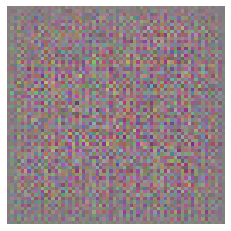

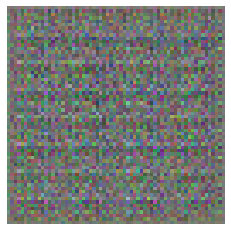

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch: 0, Iter: 50, GenLoss: 8.91748046875, DiscLoss: 0.2691871225833893, D(x): 0.9451001286506653, D(G(x)): 0.1786016970872879,0.00015736851491965353


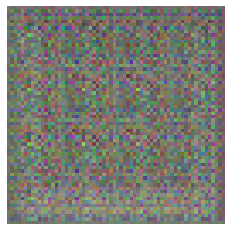

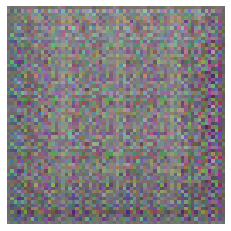

Epoch: 0, Iter: 100, GenLoss: 8.619535446166992, DiscLoss: 0.036563508212566376, D(x): 0.9708120822906494, D(G(x)): 0.002700945595279336,0.00022505743254441768


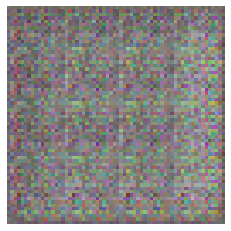

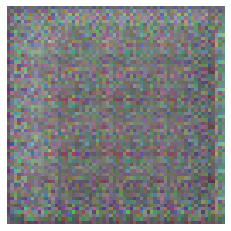

Epoch: 1, Iter: 0, GenLoss: 11.31269645690918, DiscLoss: 0.005114739760756493, D(x): 0.9949809312820435, D(G(x)): 2.2351716324919835e-05,2.2572741727344692e-05


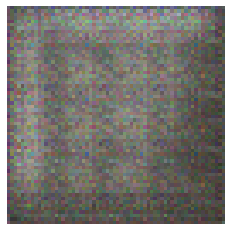

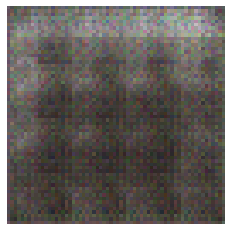

Epoch: 1, Iter: 50, GenLoss: 3.0505895614624023, DiscLoss: 0.5829552412033081, D(x): 0.738007664680481, D(G(x)): 0.09883175790309906,0.15560723841190338


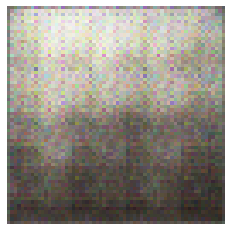

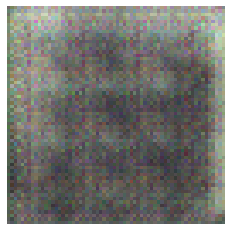

Epoch: 1, Iter: 100, GenLoss: 6.5841569900512695, DiscLoss: 0.1632244884967804, D(x): 0.887158989906311, D(G(x)): 0.025818955153226852,0.0019643972627818584


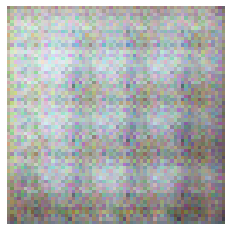

Epoch: 2, Iter: 0, GenLoss: 5.632408142089844, DiscLoss: 0.4116523861885071, D(x): 0.8815152645111084, D(G(x)): 0.17604362964630127,0.004843422211706638


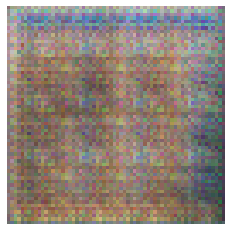

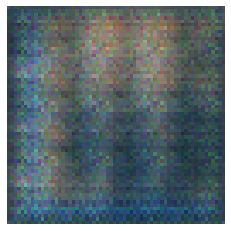

Epoch: 2, Iter: 50, GenLoss: 5.842878341674805, DiscLoss: 0.16314026713371277, D(x): 0.9384856224060059, D(G(x)): 0.055985912680625916,0.006460016593337059


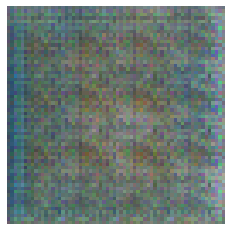

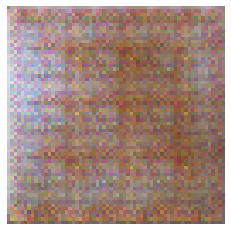

Epoch: 2, Iter: 100, GenLoss: 5.98012638092041, DiscLoss: 0.40020012855529785, D(x): 0.845007061958313, D(G(x)): 0.15241453051567078,0.004103735089302063


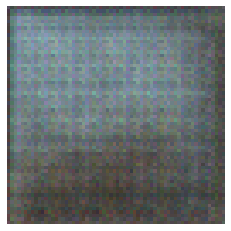

Epoch: 3, Iter: 0, GenLoss: 3.7872390747070312, DiscLoss: 0.4002411365509033, D(x): 0.9641367793083191, D(G(x)): 0.2727270722389221,0.025849182158708572


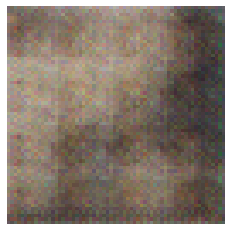

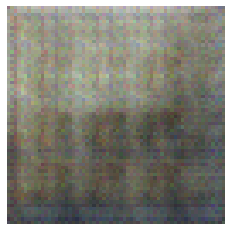

Epoch: 3, Iter: 50, GenLoss: 4.111615180969238, DiscLoss: 0.21887817978858948, D(x): 0.8675635457038879, D(G(x)): 0.041663311421871185,0.027332663536071777


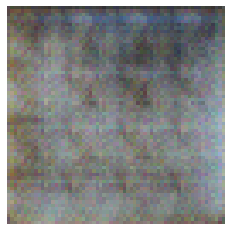

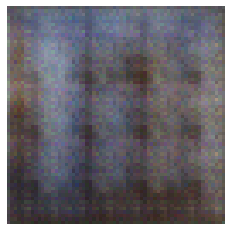

Epoch: 3, Iter: 100, GenLoss: 4.271989345550537, DiscLoss: 0.26165348291397095, D(x): 0.8587501049041748, D(G(x)): 0.08437864482402802,0.026963500306010246


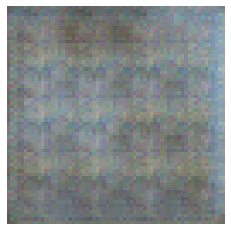

Epoch: 4, Iter: 0, GenLoss: 10.958715438842773, DiscLoss: 1.5569088459014893, D(x): 0.9114625453948975, D(G(x)): 0.6245057582855225,4.3214578909100965e-05


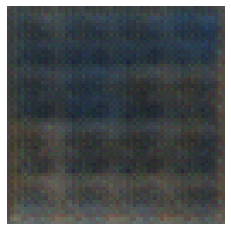

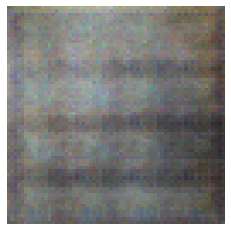

Epoch: 4, Iter: 50, GenLoss: 3.867154121398926, DiscLoss: 0.8165145516395569, D(x): 0.8519732356071472, D(G(x)): 0.40578311681747437,0.02812216430902481


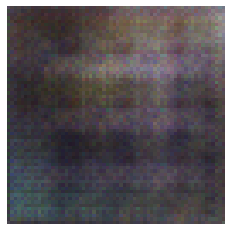

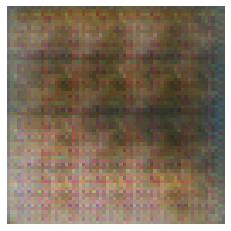

Epoch: 4, Iter: 100, GenLoss: 8.852725982666016, DiscLoss: 1.5970256328582764, D(x): 0.30374887585639954, D(G(x)): 7.780094165354967e-05,0.0004031148855574429


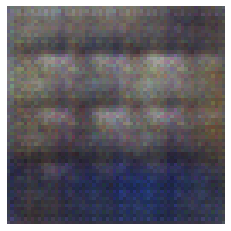

Epoch: 5, Iter: 0, GenLoss: 3.2868902683258057, DiscLoss: 1.350663185119629, D(x): 0.9832823276519775, D(G(x)): 0.6054553389549255,0.10356296598911285


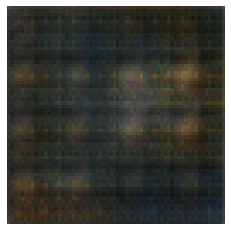

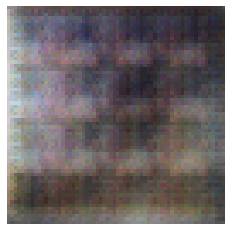

Epoch: 5, Iter: 50, GenLoss: 3.892387866973877, DiscLoss: 0.29818195104599, D(x): 0.8742200136184692, D(G(x)): 0.10498780012130737,0.028306059539318085


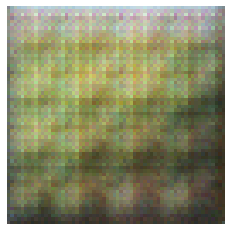

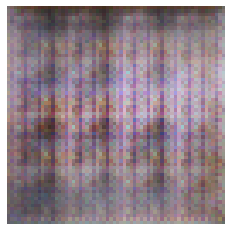

Epoch: 5, Iter: 100, GenLoss: 3.224130153656006, DiscLoss: 0.6441367268562317, D(x): 0.736158013343811, D(G(x)): 0.18295103311538696,0.056484878063201904


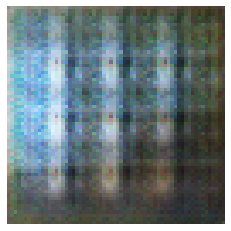

Epoch: 6, Iter: 0, GenLoss: 4.231610298156738, DiscLoss: 0.40772128105163574, D(x): 0.8606707453727722, D(G(x)): 0.20119039714336395,0.020479757338762283


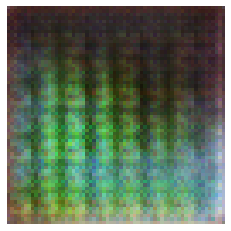

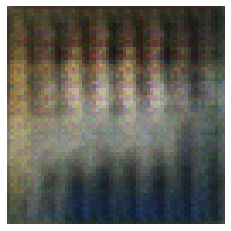

Epoch: 6, Iter: 50, GenLoss: 2.8032288551330566, DiscLoss: 0.4717031717300415, D(x): 0.7126855850219727, D(G(x)): 0.05333498865365982,0.09549026191234589


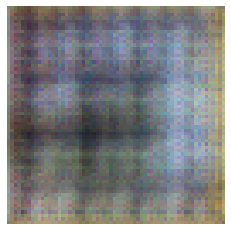

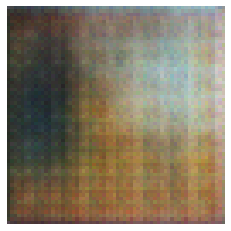

Epoch: 6, Iter: 100, GenLoss: 3.6669907569885254, DiscLoss: 0.39289817214012146, D(x): 0.7848200798034668, D(G(x)): 0.08465375006198883,0.052171867340803146


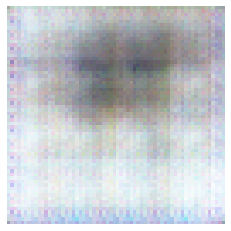

Epoch: 7, Iter: 0, GenLoss: 7.328518867492676, DiscLoss: 0.5600054264068604, D(x): 0.9609758853912354, D(G(x)): 0.33529388904571533,0.001056508393958211


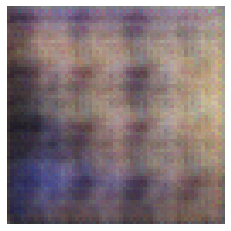

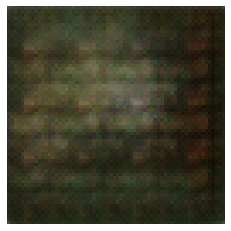

Epoch: 7, Iter: 50, GenLoss: 3.924252986907959, DiscLoss: 0.22532792389392853, D(x): 0.8359137773513794, D(G(x)): 0.02040334790945053,0.02832629345357418


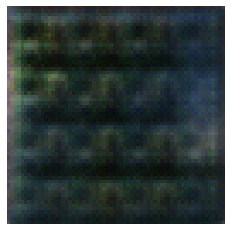

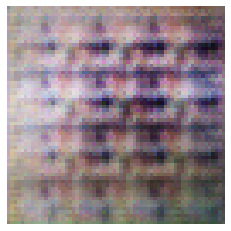

Epoch: 7, Iter: 100, GenLoss: 6.948754787445068, DiscLoss: 0.58838951587677, D(x): 0.8787757158279419, D(G(x)): 0.31096887588500977,0.001374113722704351


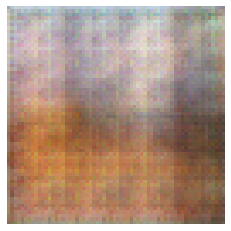

Epoch: 8, Iter: 0, GenLoss: 4.913394451141357, DiscLoss: 0.3615732491016388, D(x): 0.8454173803329468, D(G(x)): 0.15123912692070007,0.01848936453461647


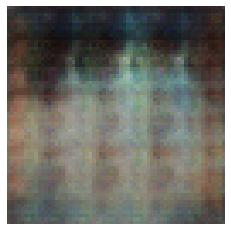

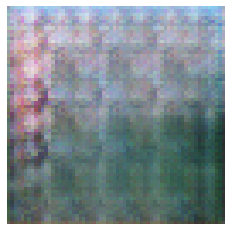

Epoch: 8, Iter: 50, GenLoss: 4.5140886306762695, DiscLoss: 0.5002281069755554, D(x): 0.8787963390350342, D(G(x)): 0.28991055488586426,0.016118215397000313


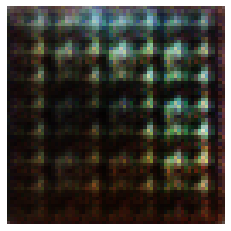

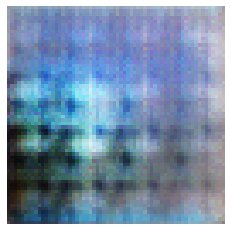

Epoch: 8, Iter: 100, GenLoss: 2.5830698013305664, DiscLoss: 1.3847509622573853, D(x): 0.34555327892303467, D(G(x)): 0.012998407706618309,0.13096654415130615


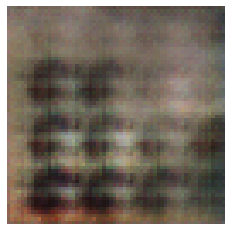

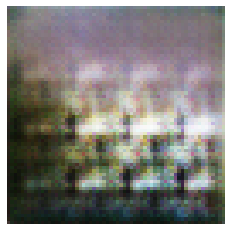

Epoch: 9, Iter: 0, GenLoss: 2.779839515686035, DiscLoss: 0.9447271227836609, D(x): 0.501899242401123, D(G(x)): 0.02959885261952877,0.08822571486234665


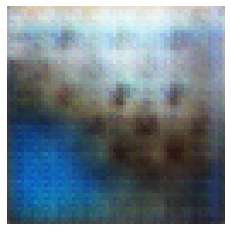

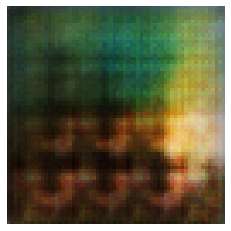

Epoch: 9, Iter: 50, GenLoss: 4.112744331359863, DiscLoss: 0.2239789366722107, D(x): 0.9603225588798523, D(G(x)): 0.1541776955127716,0.0253346748650074


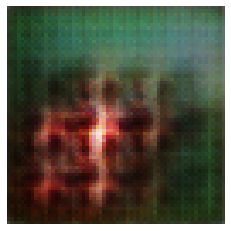

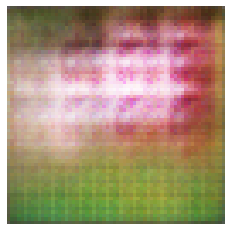

Epoch: 9, Iter: 100, GenLoss: 2.7204928398132324, DiscLoss: 0.6449909806251526, D(x): 0.6547746658325195, D(G(x)): 0.1044178158044815,0.12396721541881561


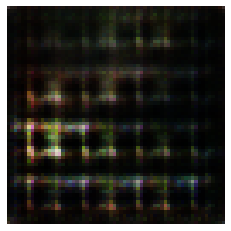

Epoch: 10, Iter: 0, GenLoss: 4.073549270629883, DiscLoss: 0.3567523956298828, D(x): 0.9074751138687134, D(G(x)): 0.18276584148406982,0.04199167340993881


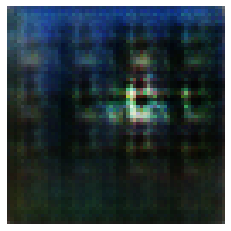

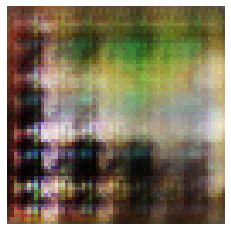

Epoch: 10, Iter: 50, GenLoss: 4.987115859985352, DiscLoss: 0.6638851165771484, D(x): 0.9076524972915649, D(G(x)): 0.3776836395263672,0.010864660143852234


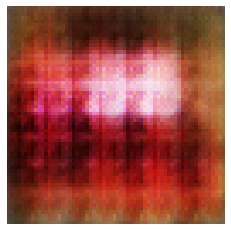

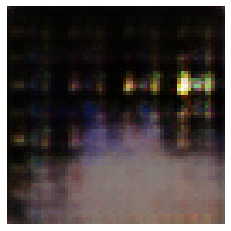

Epoch: 10, Iter: 100, GenLoss: 4.471900463104248, DiscLoss: 0.8039220571517944, D(x): 0.9316394329071045, D(G(x)): 0.4648793935775757,0.017490943893790245


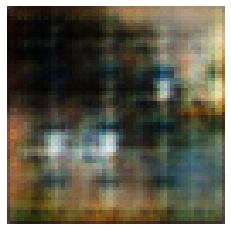

Epoch: 11, Iter: 0, GenLoss: 4.868622779846191, DiscLoss: 1.224929690361023, D(x): 0.9200373888015747, D(G(x)): 0.6028935313224792,0.011348064057528973


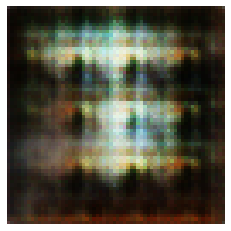

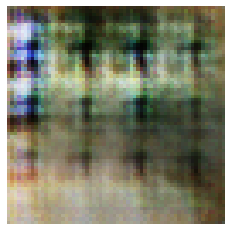

Epoch: 11, Iter: 50, GenLoss: 1.4830161333084106, DiscLoss: 1.0299532413482666, D(x): 0.5905399322509766, D(G(x)): 0.23109523952007294,0.2748183310031891


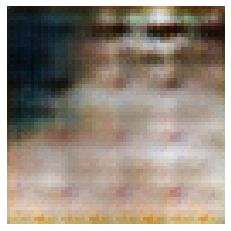

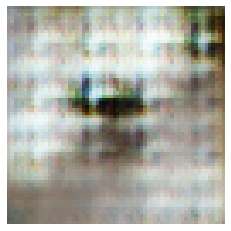

Epoch: 11, Iter: 100, GenLoss: 0.7598586082458496, DiscLoss: 1.4262908697128296, D(x): 0.3726242184638977, D(G(x)): 0.10581527650356293,0.5331567525863647


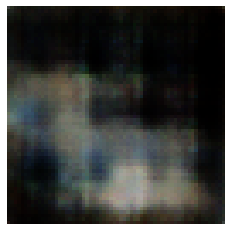

Epoch: 12, Iter: 0, GenLoss: 3.545307159423828, DiscLoss: 0.1940307319164276, D(x): 0.9109095931053162, D(G(x)): 0.08816811442375183,0.05077473074197769


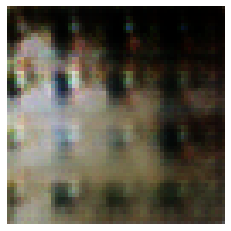

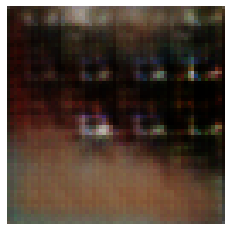

Epoch: 12, Iter: 50, GenLoss: 3.386369466781616, DiscLoss: 0.28813260793685913, D(x): 0.8550986051559448, D(G(x)): 0.09745245426893234,0.04905567318201065


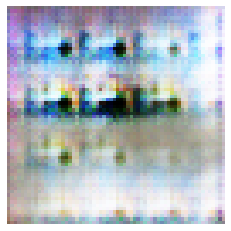

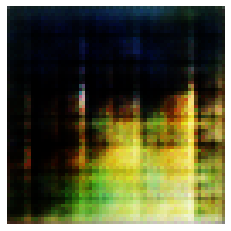

Epoch: 12, Iter: 100, GenLoss: 4.794634819030762, DiscLoss: 0.2883920967578888, D(x): 0.8427237272262573, D(G(x)): 0.09212499856948853,0.01573706604540348


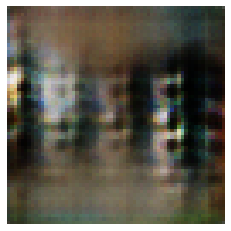

Epoch: 13, Iter: 0, GenLoss: 3.5013747215270996, DiscLoss: 0.4715999364852905, D(x): 0.6974459886550903, D(G(x)): 0.0485600009560585,0.043862875550985336


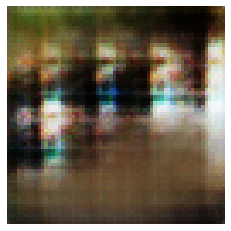

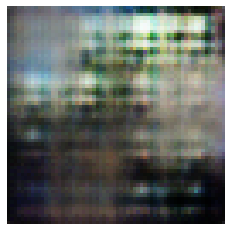

Epoch: 13, Iter: 50, GenLoss: 0.6754012703895569, DiscLoss: 0.8239822387695312, D(x): 0.5455532073974609, D(G(x)): 0.06359826773405075,0.5991424322128296


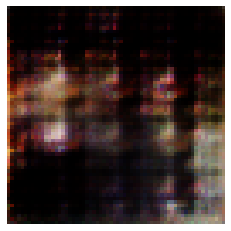

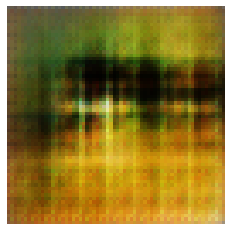

Epoch: 13, Iter: 100, GenLoss: 2.2251574993133545, DiscLoss: 0.6071372032165527, D(x): 0.6253198385238647, D(G(x)): 0.05549628660082817,0.14839228987693787


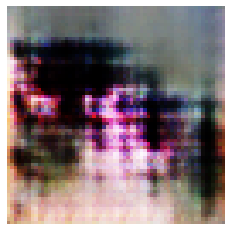

Epoch: 14, Iter: 0, GenLoss: 4.958977699279785, DiscLoss: 0.7141081094741821, D(x): 0.9259946346282959, D(G(x)): 0.4031066596508026,0.013109304010868073


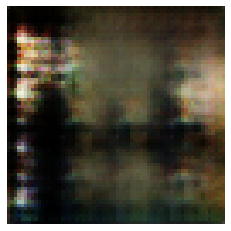

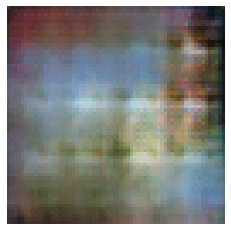

Epoch: 14, Iter: 50, GenLoss: 4.164109230041504, DiscLoss: 0.6523361206054688, D(x): 0.586197018623352, D(G(x)): 0.01062728464603424,0.033451780676841736


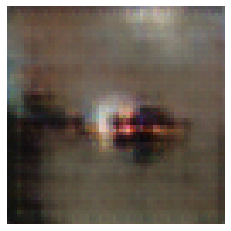

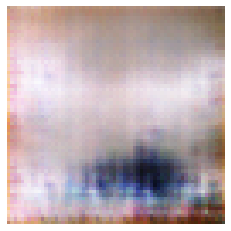

Epoch: 14, Iter: 100, GenLoss: 4.394650936126709, DiscLoss: 0.24488572776317596, D(x): 0.8462741374969482, D(G(x)): 0.04783185198903084,0.020516950637102127


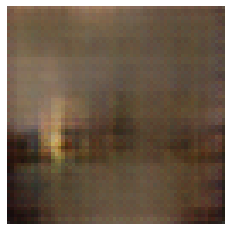

Epoch: 15, Iter: 0, GenLoss: 3.5558438301086426, DiscLoss: 0.24573832750320435, D(x): 0.8781909942626953, D(G(x)): 0.09582866728305817,0.04287606105208397


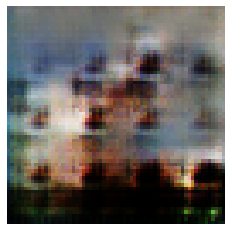

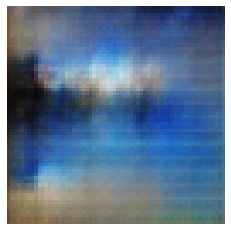

Epoch: 15, Iter: 50, GenLoss: 4.342081546783447, DiscLoss: 0.3158472180366516, D(x): 0.8718470335006714, D(G(x)): 0.12907849252223969,0.022822044789791107


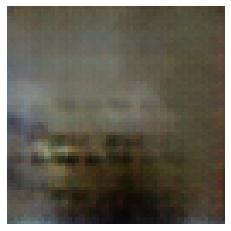

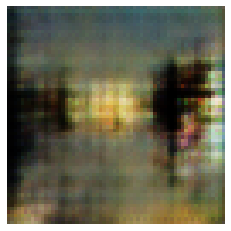

Epoch: 15, Iter: 100, GenLoss: 3.8913145065307617, DiscLoss: 1.0068891048431396, D(x): 0.4834444224834442, D(G(x)): 0.01919430121779442,0.09216582775115967


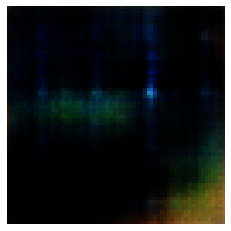

Epoch: 16, Iter: 0, GenLoss: 3.7469217777252197, DiscLoss: 0.39193302392959595, D(x): 0.8631388545036316, D(G(x)): 0.17706380784511566,0.04337555915117264


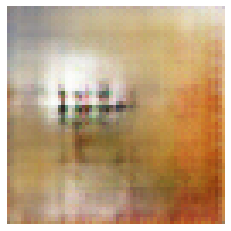

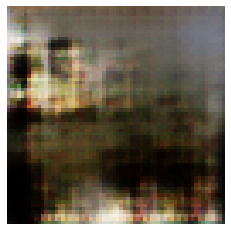

Epoch: 16, Iter: 50, GenLoss: 2.5779166221618652, DiscLoss: 0.7452710270881653, D(x): 0.5478785037994385, D(G(x)): 0.044938601553440094,0.1151542216539383


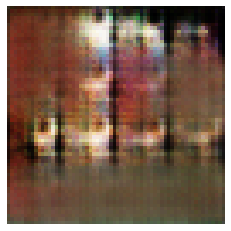

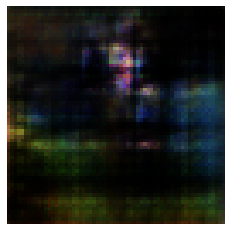

Epoch: 16, Iter: 100, GenLoss: 5.643365859985352, DiscLoss: 0.7941000461578369, D(x): 0.8267158269882202, D(G(x)): 0.38238346576690674,0.006749541498720646


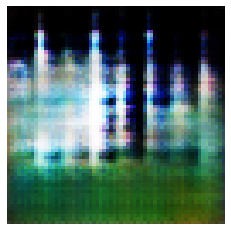

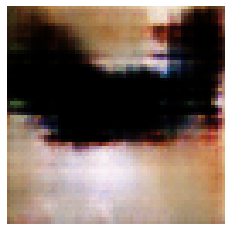

Epoch: 17, Iter: 0, GenLoss: 4.657399654388428, DiscLoss: 0.4760373532772064, D(x): 0.9287557601928711, D(G(x)): 0.2885615825653076,0.01779724285006523


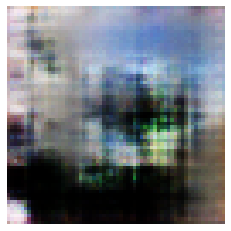

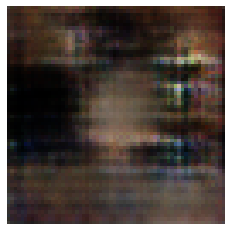

Epoch: 17, Iter: 50, GenLoss: 3.0780696868896484, DiscLoss: 0.277778685092926, D(x): 0.8724361062049866, D(G(x)): 0.11263971030712128,0.06386859714984894


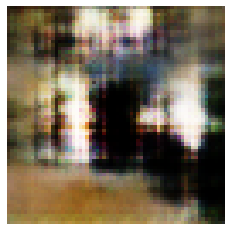

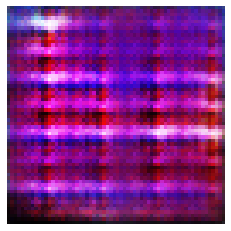

Epoch: 17, Iter: 100, GenLoss: 4.687119960784912, DiscLoss: 0.6930843591690063, D(x): 0.8594151735305786, D(G(x)): 0.3561513125896454,0.014108736999332905


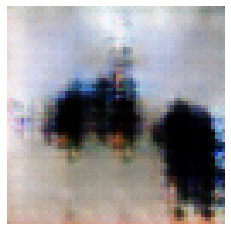

Epoch: 18, Iter: 0, GenLoss: 1.9379427433013916, DiscLoss: 0.4393012523651123, D(x): 0.737650990486145, D(G(x)): 0.085017628967762,0.18365496397018433


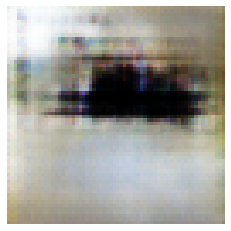

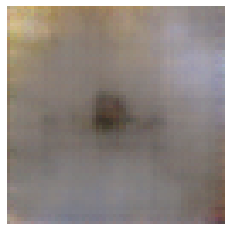

Epoch: 18, Iter: 50, GenLoss: 3.7419214248657227, DiscLoss: 0.15578849613666534, D(x): 0.9229212403297424, D(G(x)): 0.06877632439136505,0.046569183468818665


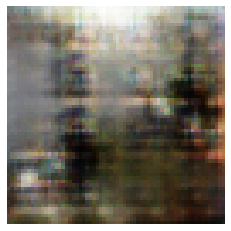

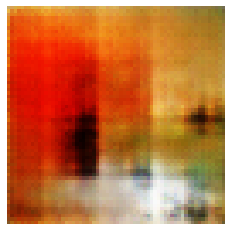

Epoch: 18, Iter: 100, GenLoss: 3.253507137298584, DiscLoss: 0.43239447474479675, D(x): 0.7876331806182861, D(G(x)): 0.13205935060977936,0.057470083236694336


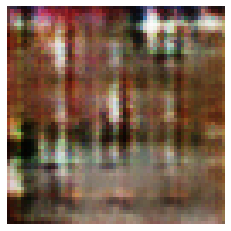

Epoch: 19, Iter: 0, GenLoss: 3.8215558528900146, DiscLoss: 0.18758749961853027, D(x): 0.973412275314331, D(G(x)): 0.14274871349334717,0.02855524979531765


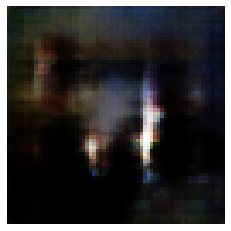

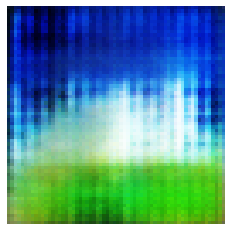

Epoch: 19, Iter: 50, GenLoss: 5.135112285614014, DiscLoss: 0.38093090057373047, D(x): 0.9083000421524048, D(G(x)): 0.2201598882675171,0.008229920640587807


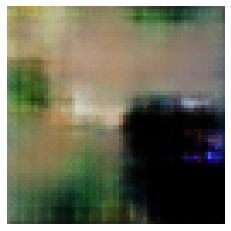

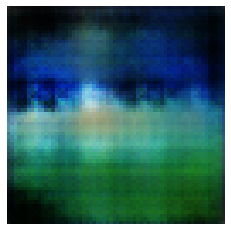

Epoch: 19, Iter: 100, GenLoss: 3.442530393600464, DiscLoss: 0.3842225670814514, D(x): 0.8632098436355591, D(G(x)): 0.17988842725753784,0.051498912274837494


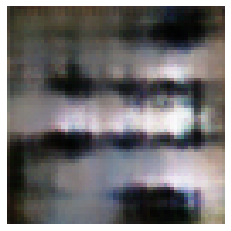

Epoch: 20, Iter: 0, GenLoss: 4.029651641845703, DiscLoss: 0.42079100012779236, D(x): 0.8803916573524475, D(G(x)): 0.21298226714134216,0.023835793137550354


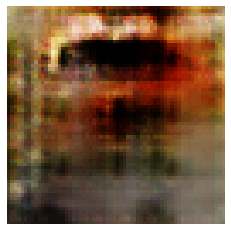

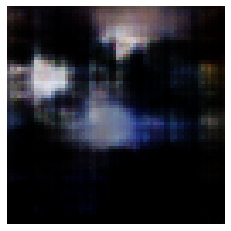

Epoch: 20, Iter: 50, GenLoss: 4.9667558670043945, DiscLoss: 0.08044205605983734, D(x): 0.9826634526252747, D(G(x)): 0.05585527420043945,0.012646441347897053


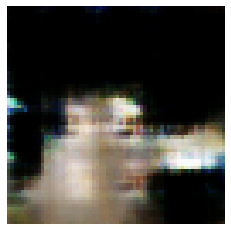

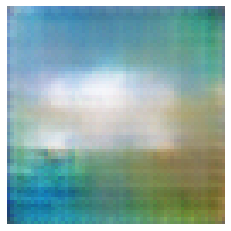

Epoch: 20, Iter: 100, GenLoss: 5.293035507202148, DiscLoss: 0.22644659876823425, D(x): 0.8814153075218201, D(G(x)): 0.071907639503479,0.007057943381369114


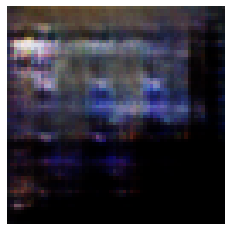

Epoch: 21, Iter: 0, GenLoss: 5.479886054992676, DiscLoss: 0.5715835690498352, D(x): 0.8945634365081787, D(G(x)): 0.31096598505973816,0.00578552158549428


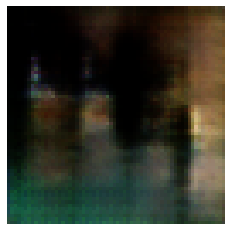

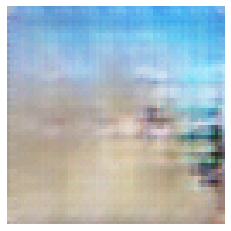

Epoch: 21, Iter: 50, GenLoss: 4.954996109008789, DiscLoss: 0.21031969785690308, D(x): 0.9128396511077881, D(G(x)): 0.09620247781276703,0.013142899610102177


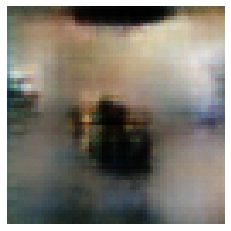

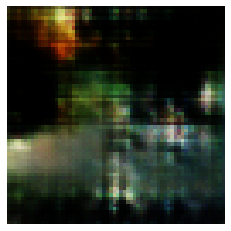

Epoch: 21, Iter: 100, GenLoss: 4.627195358276367, DiscLoss: 0.16057652235031128, D(x): 0.907498836517334, D(G(x)): 0.051644738763570786,0.01688811182975769


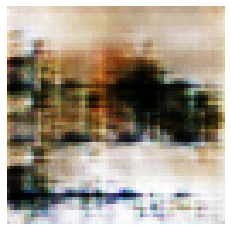

Epoch: 22, Iter: 0, GenLoss: 5.443334102630615, DiscLoss: 0.2634129822254181, D(x): 0.9812333583831787, D(G(x)): 0.1935127228498459,0.006805887445807457


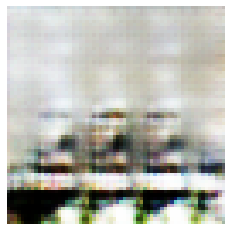

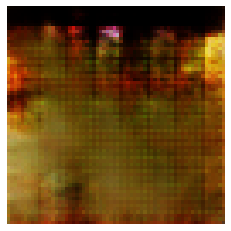

Epoch: 22, Iter: 50, GenLoss: 7.651043891906738, DiscLoss: 0.5569268465042114, D(x): 0.9792926907539368, D(G(x)): 0.36074164509773254,0.0007989957230165601


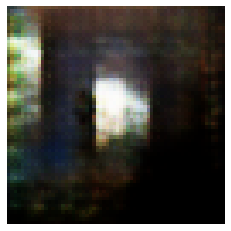

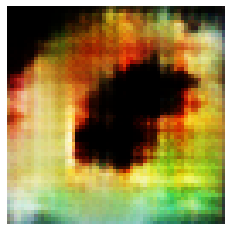

Epoch: 22, Iter: 100, GenLoss: 6.903741836547852, DiscLoss: 0.5696240067481995, D(x): 0.957642674446106, D(G(x)): 0.3336710035800934,0.0022237796802073717


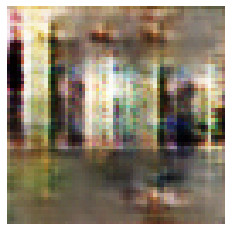

Epoch: 23, Iter: 0, GenLoss: 4.408628463745117, DiscLoss: 0.1865198314189911, D(x): 0.9731345176696777, D(G(x)): 0.13492944836616516,0.01790503039956093


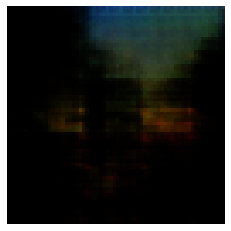

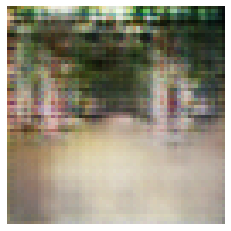

Epoch: 23, Iter: 50, GenLoss: 5.398597240447998, DiscLoss: 0.19662560522556305, D(x): 0.8971987366676331, D(G(x)): 0.0719238668680191,0.008903058245778084


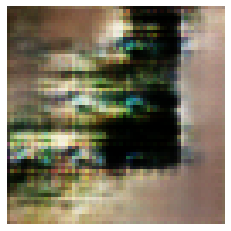

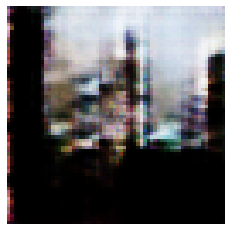

Epoch: 23, Iter: 100, GenLoss: 7.765817642211914, DiscLoss: 0.7126715779304504, D(x): 0.9856178760528564, D(G(x)): 0.41164734959602356,0.0010838565649464726


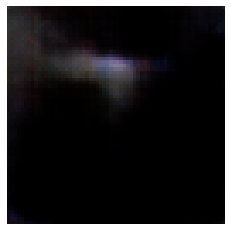

Epoch: 24, Iter: 0, GenLoss: 8.766440391540527, DiscLoss: 1.1405847072601318, D(x): 0.9821376204490662, D(G(x)): 0.5907670855522156,0.0002557769767008722


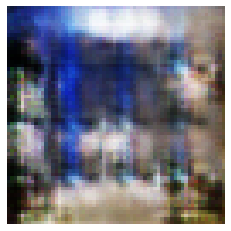

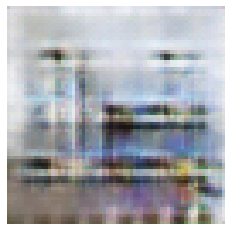

Epoch: 24, Iter: 50, GenLoss: 6.553429126739502, DiscLoss: 0.5506322383880615, D(x): 0.9196863770484924, D(G(x)): 0.29790496826171875,0.002248858567327261


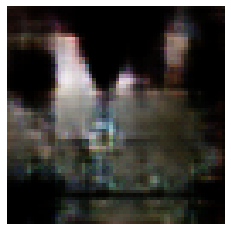

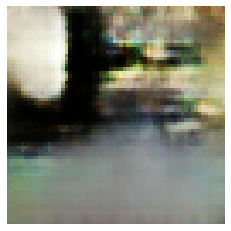

Epoch: 24, Iter: 100, GenLoss: 5.421219825744629, DiscLoss: 0.30529090762138367, D(x): 0.774665892124176, D(G(x)): 0.02178717404603958,0.015957826748490334


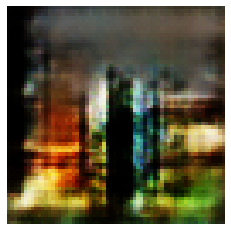

Epoch: 25, Iter: 0, GenLoss: 3.5269603729248047, DiscLoss: 0.2359274923801422, D(x): 0.8789842128753662, D(G(x)): 0.0823667049407959,0.05106765776872635


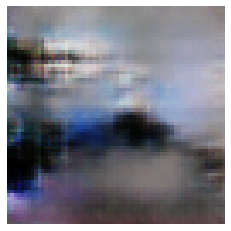

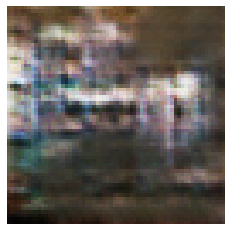

Epoch: 25, Iter: 50, GenLoss: 4.890753746032715, DiscLoss: 0.4548240900039673, D(x): 0.6954721212387085, D(G(x)): 0.019752614200115204,0.017459247261285782


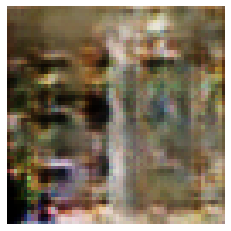

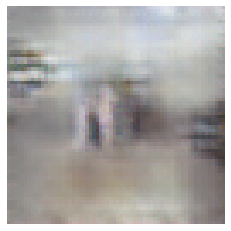

Epoch: 25, Iter: 100, GenLoss: 4.121821880340576, DiscLoss: 0.3589455485343933, D(x): 0.8893412947654724, D(G(x)): 0.18591979146003723,0.024347815662622452


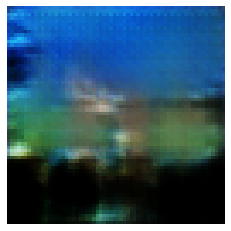

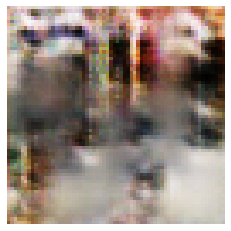

Epoch: 26, Iter: 0, GenLoss: 1.7560153007507324, DiscLoss: 0.899162232875824, D(x): 0.572152853012085, D(G(x)): 0.07267988473176956,0.2619088888168335


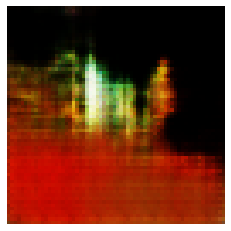

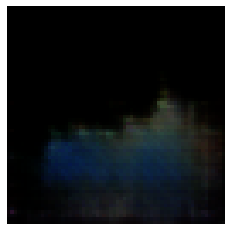

Epoch: 26, Iter: 50, GenLoss: 3.7092416286468506, DiscLoss: 0.15639403462409973, D(x): 0.9264589548110962, D(G(x)): 0.05612701177597046,0.05719922482967377


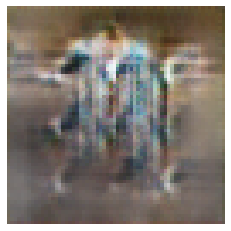

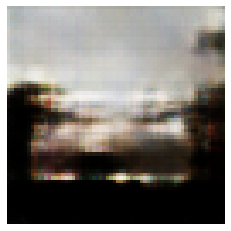

Epoch: 26, Iter: 100, GenLoss: 5.2439680099487305, DiscLoss: 0.3164675831794739, D(x): 0.9794461727142334, D(G(x)): 0.20738719403743744,0.008477307856082916


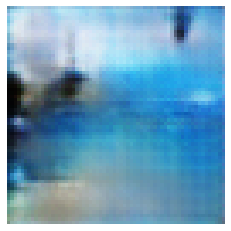

Epoch: 27, Iter: 0, GenLoss: 3.8621153831481934, DiscLoss: 1.2179100513458252, D(x): 0.4047590494155884, D(G(x)): 0.0016053952276706696,0.05288434401154518


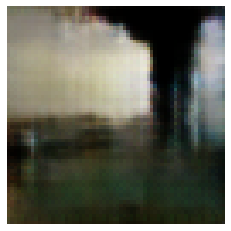

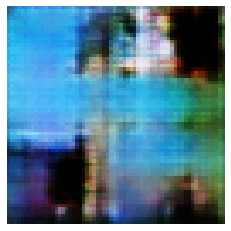

Epoch: 27, Iter: 50, GenLoss: 4.561399459838867, DiscLoss: 0.20852535963058472, D(x): 0.8691940307617188, D(G(x)): 0.04821200296282768,0.01956808753311634


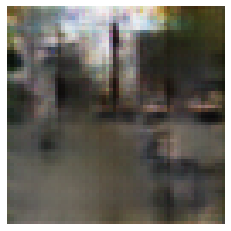

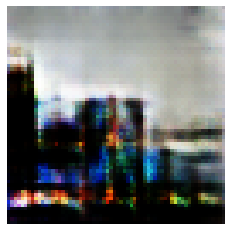

Epoch: 27, Iter: 100, GenLoss: 5.527774810791016, DiscLoss: 0.45479875802993774, D(x): 0.9548879861831665, D(G(x)): 0.29433655738830566,0.005863821133971214


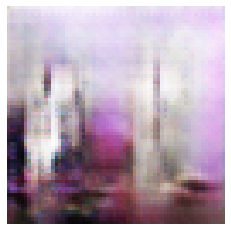

Epoch: 28, Iter: 0, GenLoss: 3.036836624145508, DiscLoss: 0.3064694404602051, D(x): 0.8261351585388184, D(G(x)): 0.08678038418292999,0.07392171025276184


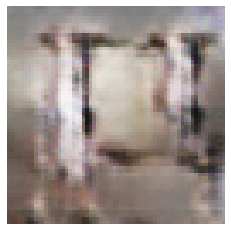

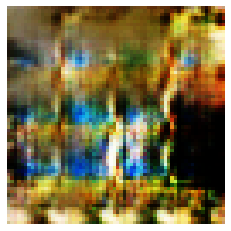

Epoch: 28, Iter: 50, GenLoss: 4.348301887512207, DiscLoss: 0.15353359282016754, D(x): 0.9200935363769531, D(G(x)): 0.06125285103917122,0.020467175170779228


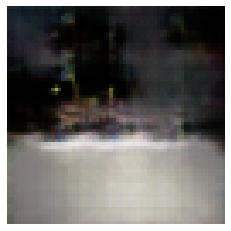

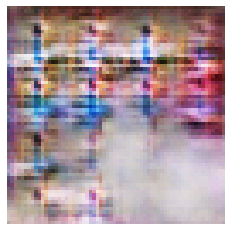

Epoch: 28, Iter: 100, GenLoss: 5.114953994750977, DiscLoss: 0.538535475730896, D(x): 0.8917291164398193, D(G(x)): 0.2874044179916382,0.00764370895922184


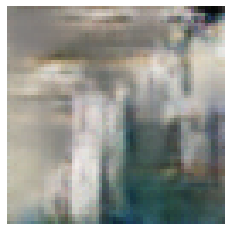

Epoch: 29, Iter: 0, GenLoss: 4.258173942565918, DiscLoss: 0.3233170211315155, D(x): 0.8204128742218018, D(G(x)): 0.046449191868305206,0.027095384895801544


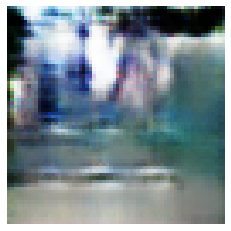

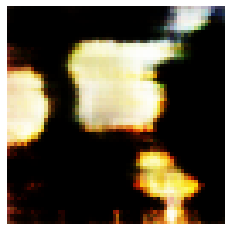

Epoch: 29, Iter: 50, GenLoss: 3.955000400543213, DiscLoss: 0.1406210958957672, D(x): 0.9392583966255188, D(G(x)): 0.06055942177772522,0.05745543912053108


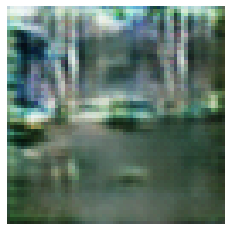

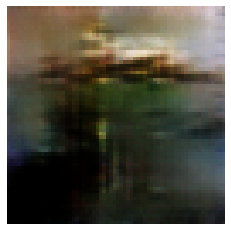

Epoch: 29, Iter: 100, GenLoss: 2.91198468208313, DiscLoss: 0.4088345468044281, D(x): 0.81537926197052, D(G(x)): 0.13457860052585602,0.10165658593177795


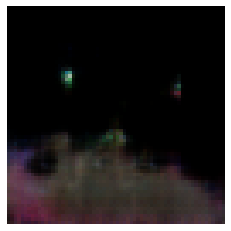

Epoch: 30, Iter: 0, GenLoss: 3.736802339553833, DiscLoss: 0.22578991949558258, D(x): 0.8337896466255188, D(G(x)): 0.017415843904018402,0.042679134756326675


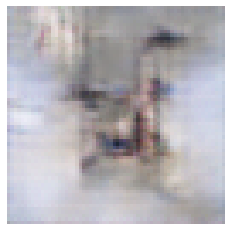

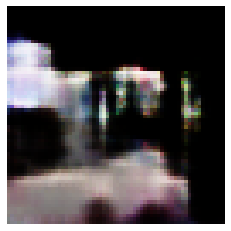

Epoch: 30, Iter: 50, GenLoss: 5.92976188659668, DiscLoss: 0.7043101191520691, D(x): 0.9551863670349121, D(G(x)): 0.3875052034854889,0.0044696517288684845


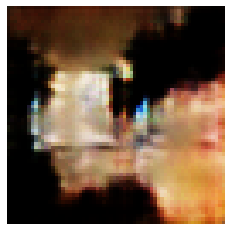

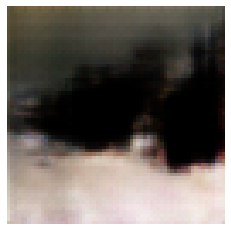

Epoch: 30, Iter: 100, GenLoss: 5.278261184692383, DiscLoss: 0.2729765772819519, D(x): 0.9647774696350098, D(G(x)): 0.18881632387638092,0.008417490869760513


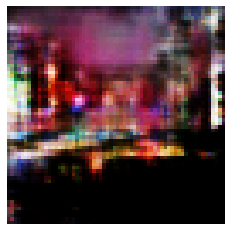

Epoch: 31, Iter: 0, GenLoss: 3.5705795288085938, DiscLoss: 0.4165172576904297, D(x): 0.8138313889503479, D(G(x)): 0.1417497992515564,0.06733383238315582


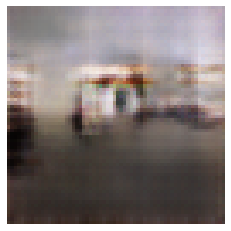

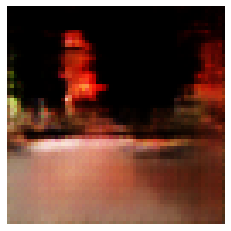

Epoch: 31, Iter: 50, GenLoss: 4.828502178192139, DiscLoss: 0.36683371663093567, D(x): 0.9008756875991821, D(G(x)): 0.20565061271190643,0.011800378561019897


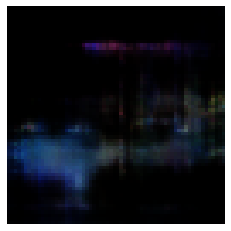

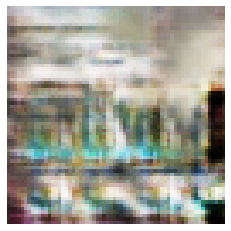

Epoch: 31, Iter: 100, GenLoss: 3.3329885005950928, DiscLoss: 0.4748559892177582, D(x): 0.7687184810638428, D(G(x)): 0.13089153170585632,0.06071959435939789


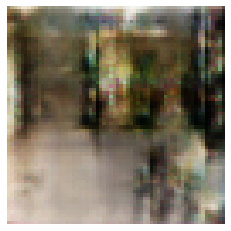

Epoch: 32, Iter: 0, GenLoss: 7.441521167755127, DiscLoss: 1.5757554769515991, D(x): 0.9335260391235352, D(G(x)): 0.6628215909004211,0.0019180490635335445


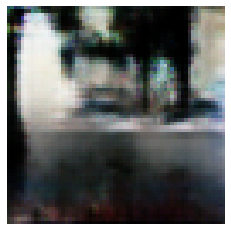

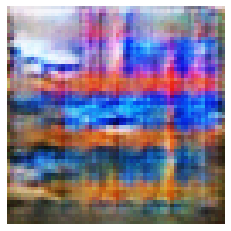

Epoch: 32, Iter: 50, GenLoss: 4.428703784942627, DiscLoss: 0.13064683973789215, D(x): 0.9880081415176392, D(G(x)): 0.10472363978624344,0.017668839544057846


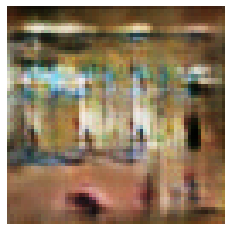

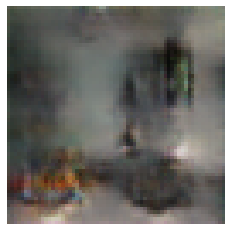

Epoch: 32, Iter: 100, GenLoss: 7.736301422119141, DiscLoss: 0.8183383941650391, D(x): 0.9950448870658875, D(G(x)): 0.4412323236465454,0.0008684885688126087


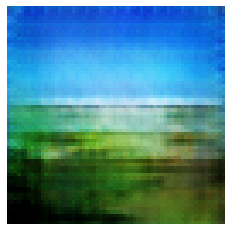

Epoch: 33, Iter: 0, GenLoss: 4.8613505363464355, DiscLoss: 0.2476983368396759, D(x): 0.9606705904006958, D(G(x)): 0.1688876748085022,0.0112779401242733


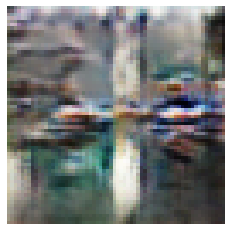

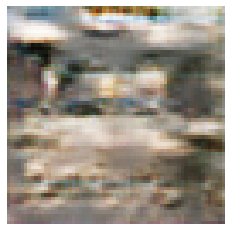

Epoch: 33, Iter: 50, GenLoss: 4.39301872253418, DiscLoss: 0.230368971824646, D(x): 0.9800523519515991, D(G(x)): 0.1637887805700302,0.01769500970840454


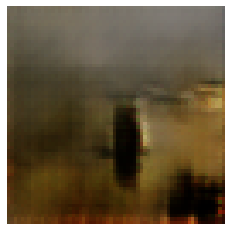

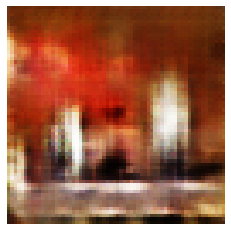

Epoch: 33, Iter: 100, GenLoss: 3.859570264816284, DiscLoss: 0.3387719392776489, D(x): 0.8921234607696533, D(G(x)): 0.1749477982521057,0.03242679312825203


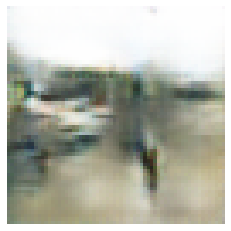

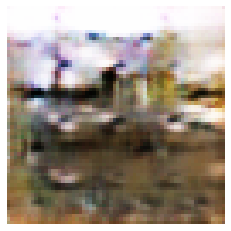

Epoch: 34, Iter: 0, GenLoss: 5.561402320861816, DiscLoss: 0.5926163792610168, D(x): 0.9320363998413086, D(G(x)): 0.3274540305137634,0.006135664880275726


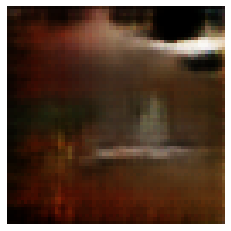

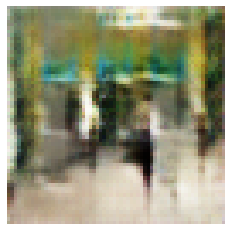

Epoch: 34, Iter: 50, GenLoss: 2.653947114944458, DiscLoss: 1.3610371351242065, D(x): 0.3926684260368347, D(G(x)): 0.007145808544009924,0.1335376501083374


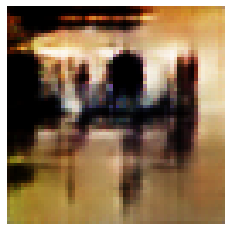

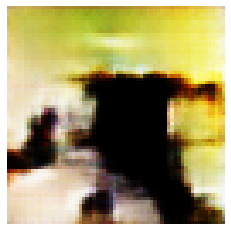

Epoch: 34, Iter: 100, GenLoss: 6.729220390319824, DiscLoss: 0.4636804163455963, D(x): 0.6846445798873901, D(G(x)): 0.0030333874747157097,0.0033440617844462395


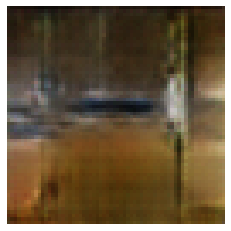

Epoch: 35, Iter: 0, GenLoss: 3.7961618900299072, DiscLoss: 0.33214929699897766, D(x): 0.7876954078674316, D(G(x)): 0.04202478006482124,0.03942476958036423


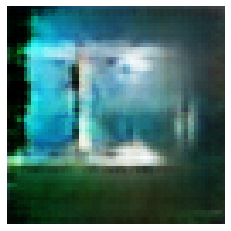

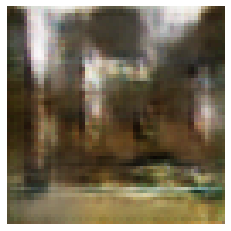

Epoch: 35, Iter: 50, GenLoss: 8.014949798583984, DiscLoss: 0.07969238609075546, D(x): 0.9358080625534058, D(G(x)): 0.006050813011825085,0.000853543751873076


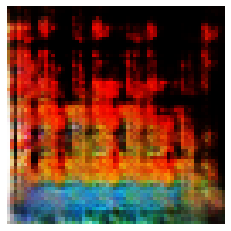

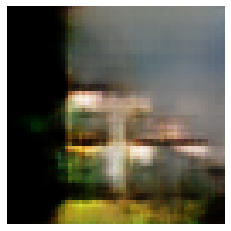

Epoch: 35, Iter: 100, GenLoss: 4.852474212646484, DiscLoss: 0.22296850383281708, D(x): 0.9678258895874023, D(G(x)): 0.15238329768180847,0.013589433394372463


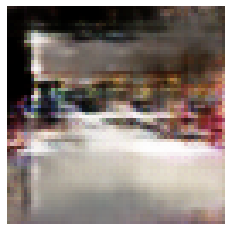

Epoch: 36, Iter: 0, GenLoss: 4.732959747314453, DiscLoss: 0.2651975154876709, D(x): 0.8396568298339844, D(G(x)): 0.05649931728839874,0.016527680680155754


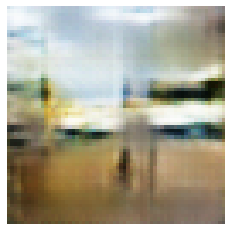

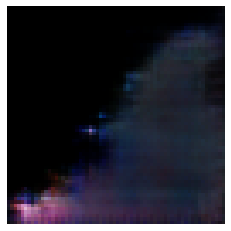

Epoch: 36, Iter: 50, GenLoss: 2.6990785598754883, DiscLoss: 0.4016289710998535, D(x): 0.7376739382743835, D(G(x)): 0.021458853036165237,0.08882822096347809


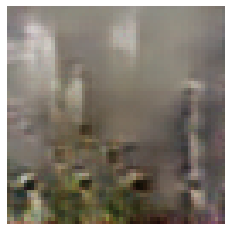

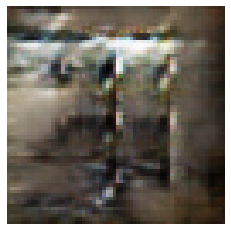

Epoch: 36, Iter: 100, GenLoss: 4.432199478149414, DiscLoss: 0.18763208389282227, D(x): 0.9532144069671631, D(G(x)): 0.12161748856306076,0.022519856691360474


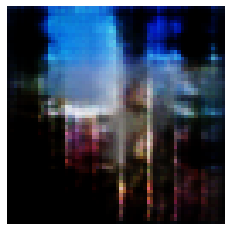

Epoch: 37, Iter: 0, GenLoss: 3.960862398147583, DiscLoss: 0.20904386043548584, D(x): 0.9206081628799438, D(G(x)): 0.10755395889282227,0.02930799126625061


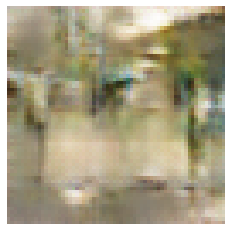

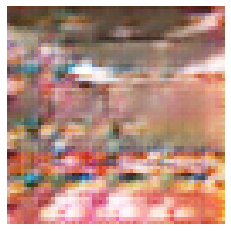

Epoch: 37, Iter: 50, GenLoss: 4.585453987121582, DiscLoss: 0.13526654243469238, D(x): 0.9461492300033569, D(G(x)): 0.069188192486763,0.01653638295829296


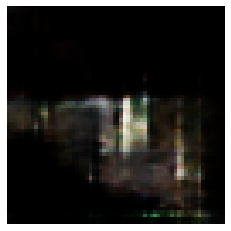

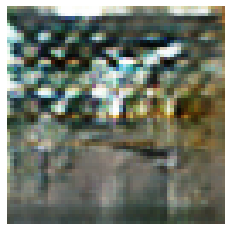

Epoch: 37, Iter: 100, GenLoss: 3.3011586666107178, DiscLoss: 0.6375914812088013, D(x): 0.6266971826553345, D(G(x)): 0.005082923918962479,0.07362779974937439


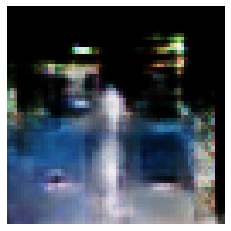

Epoch: 38, Iter: 0, GenLoss: 4.9504499435424805, DiscLoss: 0.2594679594039917, D(x): 0.8131272196769714, D(G(x)): 0.02093886211514473,0.013820807449519634


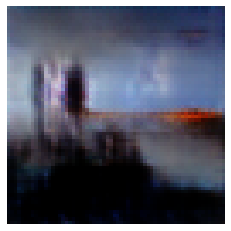

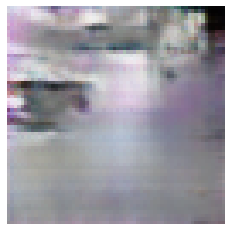

Epoch: 38, Iter: 50, GenLoss: 4.008133888244629, DiscLoss: 0.2326759248971939, D(x): 0.9052528738975525, D(G(x)): 0.10560721904039383,0.02649657055735588


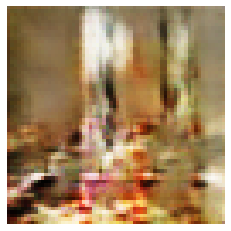

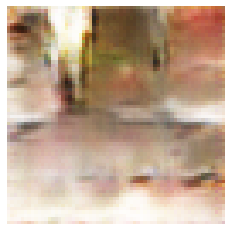

Epoch: 38, Iter: 100, GenLoss: 3.291698932647705, DiscLoss: 0.1757006049156189, D(x): 0.9665367603302002, D(G(x)): 0.11334681510925293,0.0775919109582901


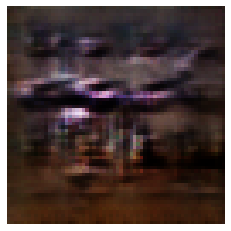

Epoch: 39, Iter: 0, GenLoss: 8.508214950561523, DiscLoss: 1.2673981189727783, D(x): 0.8107369542121887, D(G(x)): 0.5186613202095032,0.0006600060150958598


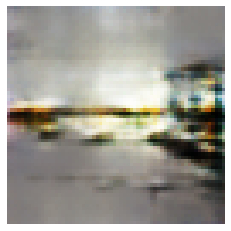

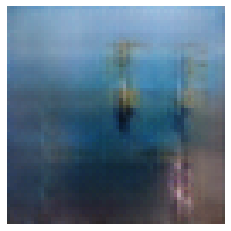

Epoch: 39, Iter: 50, GenLoss: 3.868536949157715, DiscLoss: 0.19272100925445557, D(x): 0.8725099563598633, D(G(x)): 0.0417889729142189,0.04078959673643112


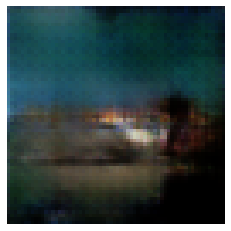

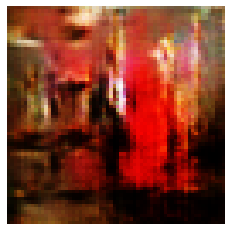

Epoch: 39, Iter: 100, GenLoss: 4.578653335571289, DiscLoss: 0.35402393341064453, D(x): 0.9099236726760864, D(G(x)): 0.1731877624988556,0.01863851211965084


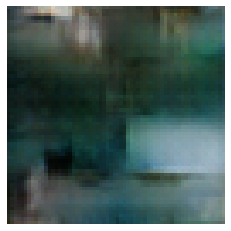

Epoch: 40, Iter: 0, GenLoss: 4.824471473693848, DiscLoss: 0.08313203603029251, D(x): 0.9863861799240112, D(G(x)): 0.06368766725063324,0.013894017785787582


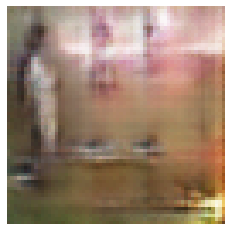

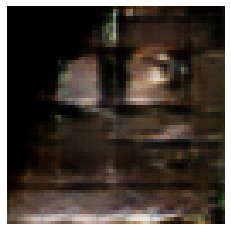

Epoch: 40, Iter: 50, GenLoss: 1.7532353401184082, DiscLoss: 1.9469385147094727, D(x): 0.19826704263687134, D(G(x)): 0.001565079903230071,0.2976354956626892


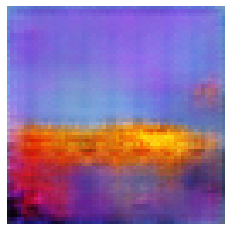

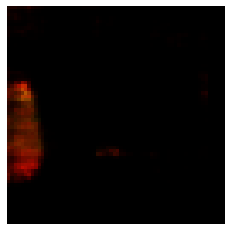

Epoch: 40, Iter: 100, GenLoss: 4.351316452026367, DiscLoss: 0.31598028540611267, D(x): 0.7985079288482666, D(G(x)): 0.02815455012023449,0.023868123069405556


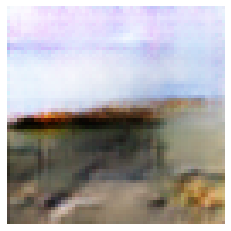

Epoch: 41, Iter: 0, GenLoss: 7.068655967712402, DiscLoss: 0.9086728692054749, D(x): 0.990653932094574, D(G(x)): 0.5058367252349854,0.0019631783943623304


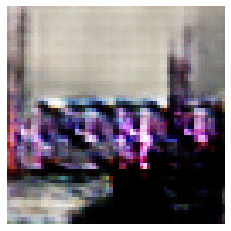

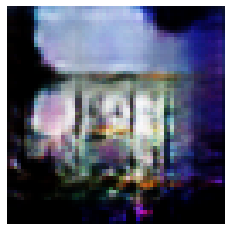

Epoch: 41, Iter: 50, GenLoss: 2.8999691009521484, DiscLoss: 0.25718292593955994, D(x): 0.8261824250221252, D(G(x)): 0.04719182103872299,0.08989856392145157


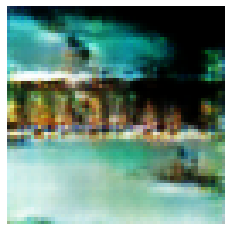

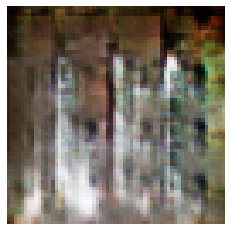

Epoch: 41, Iter: 100, GenLoss: 5.691806793212891, DiscLoss: 0.06830693036317825, D(x): 0.9797693490982056, D(G(x)): 0.042363591492176056,0.006267675198614597


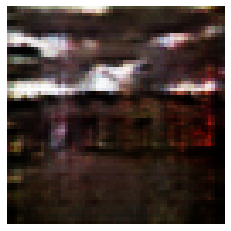

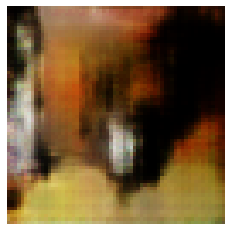

Epoch: 42, Iter: 0, GenLoss: 6.842123031616211, DiscLoss: 0.37559986114501953, D(x): 0.9757988452911377, D(G(x)): 0.2115338146686554,0.002633919008076191


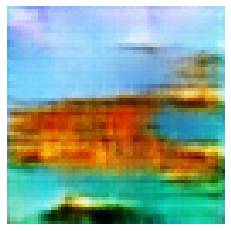

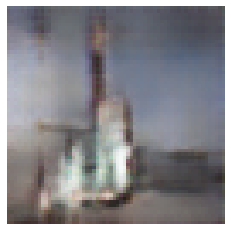

Epoch: 42, Iter: 50, GenLoss: 3.3619627952575684, DiscLoss: 0.44523316621780396, D(x): 0.7997753620147705, D(G(x)): 0.15369245409965515,0.053856752812862396


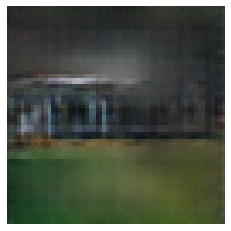

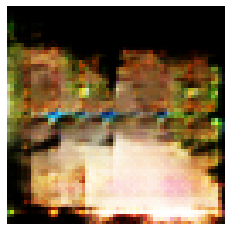

Epoch: 42, Iter: 100, GenLoss: 3.080256223678589, DiscLoss: 0.42253416776657104, D(x): 0.7129070162773132, D(G(x)): 0.013628196902573109,0.07873700559139252


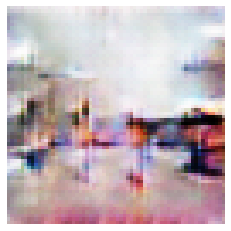

Epoch: 43, Iter: 0, GenLoss: 3.9971835613250732, DiscLoss: 0.13038469851016998, D(x): 0.9405292868614197, D(G(x)): 0.06116640567779541,0.03213053196668625


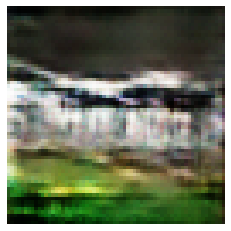

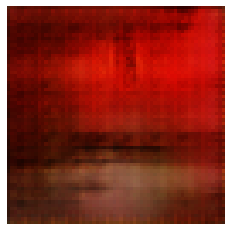

Epoch: 43, Iter: 50, GenLoss: 4.324828147888184, DiscLoss: 1.1521307229995728, D(x): 0.42319080233573914, D(G(x)): 0.003735651494935155,0.04359029233455658


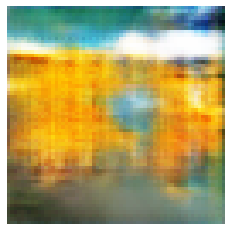

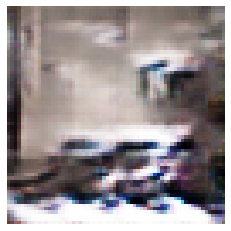

Epoch: 43, Iter: 100, GenLoss: 3.916442394256592, DiscLoss: 0.12751281261444092, D(x): 0.9514303207397461, D(G(x)): 0.07006622105836868,0.030805665999650955


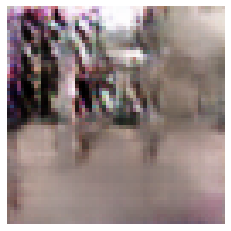

Epoch: 44, Iter: 0, GenLoss: 3.9621992111206055, DiscLoss: 0.24419881403446198, D(x): 0.9185400009155273, D(G(x)): 0.12959012389183044,0.025670107454061508


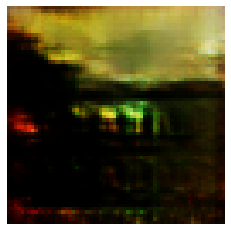

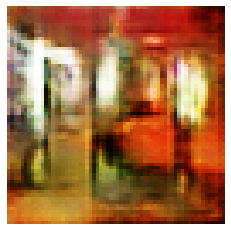

Epoch: 44, Iter: 50, GenLoss: 5.0135393142700195, DiscLoss: 0.06607483327388763, D(x): 0.9504290223121643, D(G(x)): 0.013295690529048443,0.014287401922047138


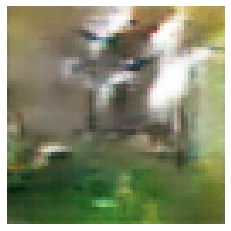

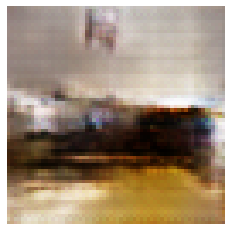

Epoch: 44, Iter: 100, GenLoss: 7.151540756225586, DiscLoss: 0.7801445722579956, D(x): 0.9866317510604858, D(G(x)): 0.47082340717315674,0.0012950581731274724


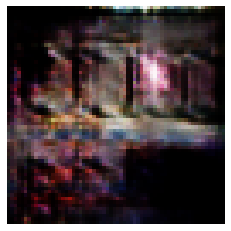

Epoch: 45, Iter: 0, GenLoss: 5.781443119049072, DiscLoss: 0.5294323563575745, D(x): 0.9665309190750122, D(G(x)): 0.30502212047576904,0.005694541148841381


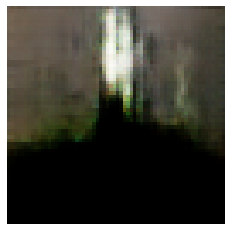

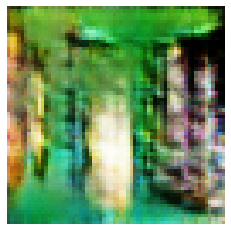

Epoch: 45, Iter: 50, GenLoss: 12.208671569824219, DiscLoss: 1.7818964719772339, D(x): 0.9980196952819824, D(G(x)): 0.757091224193573,2.074151052511297e-05


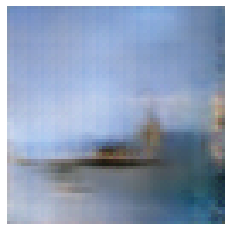

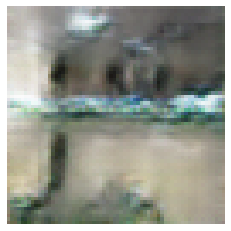

Epoch: 45, Iter: 100, GenLoss: 3.8019397258758545, DiscLoss: 0.21088793873786926, D(x): 0.8515130281448364, D(G(x)): 0.03322172164916992,0.04952065646648407


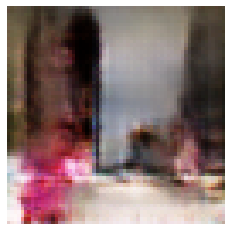

Epoch: 46, Iter: 0, GenLoss: 5.344643592834473, DiscLoss: 0.1914149671792984, D(x): 0.9879782795906067, D(G(x)): 0.15372918546199799,0.00708669051527977


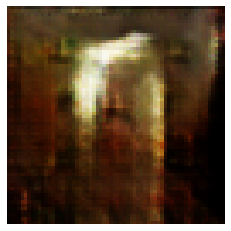

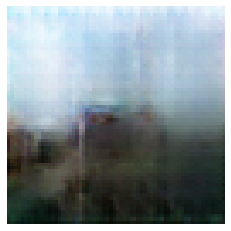

Epoch: 46, Iter: 50, GenLoss: 5.522218704223633, DiscLoss: 0.19561095535755157, D(x): 0.9840762615203857, D(G(x)): 0.14611607789993286,0.006590838544070721


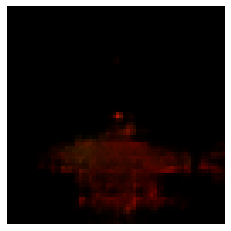

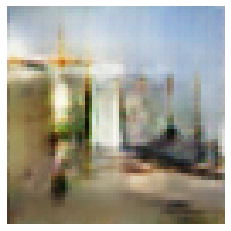

Epoch: 46, Iter: 100, GenLoss: 2.1670408248901367, DiscLoss: 0.46773046255111694, D(x): 0.6961909532546997, D(G(x)): 0.03678438067436218,0.18180516362190247


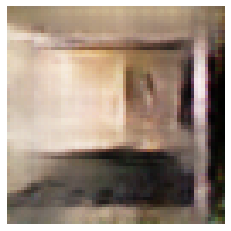

Epoch: 47, Iter: 0, GenLoss: 4.554256916046143, DiscLoss: 0.2044125497341156, D(x): 0.8605730533599854, D(G(x)): 0.023925574496388435,0.028501830995082855


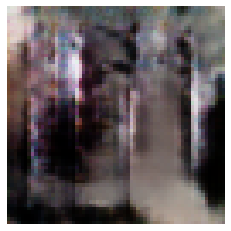

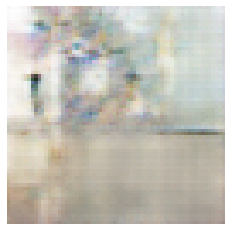

Epoch: 47, Iter: 50, GenLoss: 5.220782279968262, DiscLoss: 0.17996475100517273, D(x): 0.8617333769798279, D(G(x)): 0.015303874388337135,0.014924171380698681


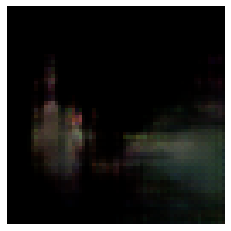

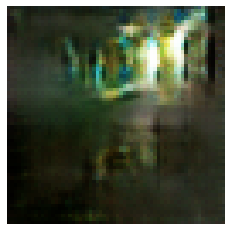

Epoch: 47, Iter: 100, GenLoss: 5.240005970001221, DiscLoss: 0.13268639147281647, D(x): 0.9720673561096191, D(G(x)): 0.09087542444467545,0.007133553270250559


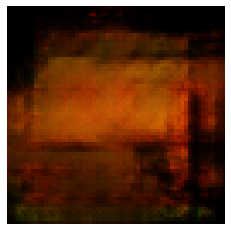

Epoch: 48, Iter: 0, GenLoss: 6.214210510253906, DiscLoss: 0.11236414313316345, D(x): 0.9904894828796387, D(G(x)): 0.08260349929332733,0.004546212963759899


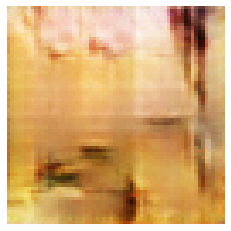

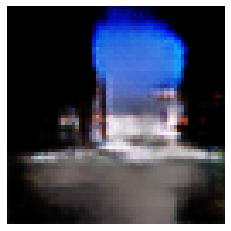

Epoch: 48, Iter: 50, GenLoss: 1.063810110092163, DiscLoss: 0.9816597700119019, D(x): 0.47081074118614197, D(G(x)): 0.021833980455994606,0.4684602916240692


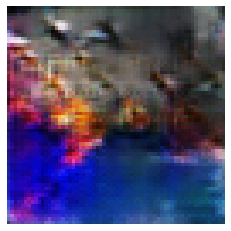

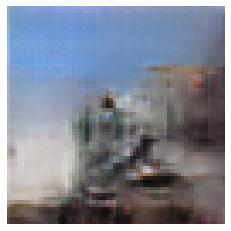

Epoch: 48, Iter: 100, GenLoss: 5.322538375854492, DiscLoss: 0.15274430811405182, D(x): 0.9727030992507935, D(G(x)): 0.1035304144024849,0.01303364709019661


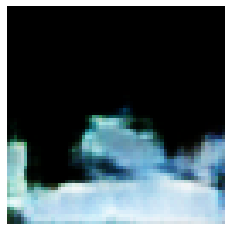

Epoch: 49, Iter: 0, GenLoss: 5.854963779449463, DiscLoss: 0.12374953925609589, D(x): 0.9827842712402344, D(G(x)): 0.09363315999507904,0.005533092189580202


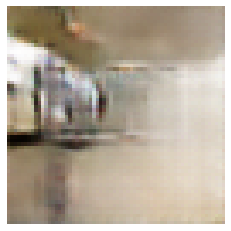

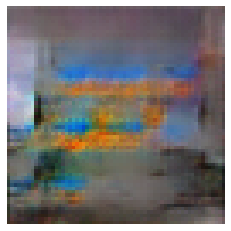

Epoch: 49, Iter: 50, GenLoss: 2.095734119415283, DiscLoss: 0.8087807893753052, D(x): 0.5692421197891235, D(G(x)): 0.008027251809835434,0.20188727974891663


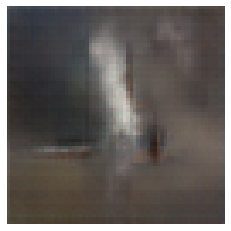

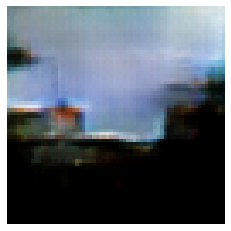

Epoch: 49, Iter: 100, GenLoss: 3.5429582595825195, DiscLoss: 0.13979779183864594, D(x): 0.9183782339096069, D(G(x)): 0.043541502207517624,0.05753150209784508


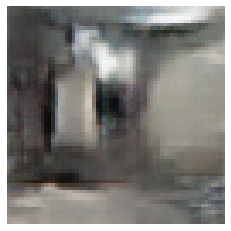

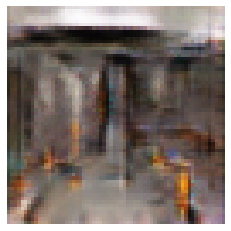

In [17]:
img_list = []
G_loss = []
D_loss = []
iters = 0
for ep in range(epochs):
  for i, data in enumerate(liminal_loader, 0):

    ### Update Discriminator Network ###

    ## train with all real batch ##
    DiscNet.zero_grad()
    # format batch
    real_cpu = data[0].to(device)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    # forward pass real batch through D
    output = DiscNet(real_cpu).view(-1)
    # calc loss on all-real batch
    errD_real = criterion(output, label)
    # calc gradients for D in backward pass
    errD_real.backward()
    D_x = output.mean().item()

    ## train with all fake batch ##
    # generate batch of latent vectors
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    # generate fake image 
    fake = GenNet(noise)
    label.fill_(fake_label)
    # classify fake batch with D
    output = DiscNet(fake.detach()).view(-1)
    # calculate D's loss on the all fake batch
    errD_fake = criterion(output, label)
    # calc gradients for this batch
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    # compute error of D as sum over fake and real batches
    errD = errD_real + errD_fake
    # update D
    optD.step()

    ### Update Generator Network ###
    GenNet.zero_grad()
    label.fill_(real_label) # fake labels are real for generator cost
    # since we just updated D, do all fake forward pass through D again
    output = DiscNet(fake).view(-1)
    # calc Generator loss based on output
    errG = criterion(output, label)
    # calc gradients for Generator
    errG.backward()
    D_G_z2 = output.mean().item()
    # Update generator 
    optG.step()

    # output training stats
    if i%50 == 0:
      print(f"Epoch: {ep}, Iter: {i}, GenLoss: {errG.item()}, DiscLoss: {errD.item()}, D(x): {D_x}, D(G(x)): {D_G_z1},{D_G_z2}")
    # check images 
    if (iters % 25==0) or ((ep==epochs-1) and (i==len(liminal_loader)-1)):
      with torch.no_grad():
        fake = GenNet(noise).detach().cpu()
        y = fake[0]*torch.tensor(STD)[:, None, None] + torch.tensor(MEAN)[:, None, None]
        plt.imshow(y.permute(1,2,0))
        plt.axis("off")
        plt.show()
      img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))
    iters+=1

In [ ]:
#noise = torch.randn(IMG_SIZE, nz, 1, 1, device=device)
img = GenNet(noise).detach().cpu()
#fig, ax = plt.subplots(1,15)
#fig.set_figheight(30)
#fig.set_figwidth(30)
plt.figure(figsize=(30,30))
for i in range(15):
  plt.subplot(7,5,i+1)
  y = img[i]*torch.tensor(STD)[:, None, None] + torch.tensor(MEAN)[:, None, None]
  plt.imshow(y.permute(1,2,0))
  plt.axis("off")
  #ax[i].imshow(y.permute(1,2,0))
  #ax[i].axis("off")

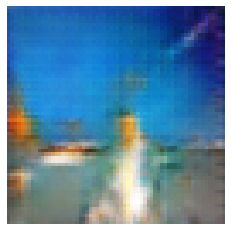

In [60]:
z = img[9]*torch.tensor(STD)[:, None, None] + torch.tensor(MEAN)[:, None, None]
plt.imshow(z.permute(1,2,0))
plt.axis("off")
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [45]:
torch.save(GenNet.state_dict(), "Generator.pth")
torch.save(DiscNet.state_dict(), "Discriminator.pth")